# Dropsonde Based Surface Evaporation per flight

This routine calculates the surface evaporation from the dropsondes over sea surface. The formula relies on Howland et al. (1983,https://doi.org/10.1175/1520-0493(1983)111<2255:TMBOTN>2.0.CO;2 )

E=C_d*rho_a*(q_s-q_a)*v --> (actually this formula comes from Rao et al. (1981))

C_d   : drag coefficient( 1.4e-3 for v< 13 m/s, 1.6e-3 for v>13m/s)
rho_a : air density at sea level
q_s   : saturation specific humidity
q_a   : actual specific humidity

## Configuration

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Predefinitions

In [2]:
campaign="HALO_AC3"
ar_of_day="AR_entire_1"
calibrated_hamp=True
flight=["RF05"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"

scalar_based_div=False
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


## Prepare Dropsonde Data

In [3]:
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))

In [4]:
#[*Dropsondes.keys()]

In [5]:
temp_sonde=Dropsondes["tdry"].copy()
wind_sonde=Dropsondes["wspd"].copy()
shum_sonde=Dropsondes["q"].copy()
pres_sonde=Dropsondes["pres"].copy()

In [6]:
# Get ERA5 sea surface temperature at sonde positions
sst=halo_era5["Interp_SST"]
sst.index

DatetimeIndex(['2022-03-15 10:11:00', '2022-03-15 10:11:01',
               '2022-03-15 10:11:02', '2022-03-15 10:11:03',
               '2022-03-15 10:11:04', '2022-03-15 10:11:05',
               '2022-03-15 10:11:06', '2022-03-15 10:11:07',
               '2022-03-15 10:11:08', '2022-03-15 10:11:09',
               ...
               '2022-03-15 13:15:50', '2022-03-15 13:15:51',
               '2022-03-15 13:15:52', '2022-03-15 13:15:53',
               '2022-03-15 13:15:54', '2022-03-15 13:15:55',
               '2022-03-15 13:15:56', '2022-03-15 13:15:57',
               '2022-03-15 13:15:58', '2022-03-15 13:15:59'],
              dtype='datetime64[ns]', name='time', length=11100, freq=None)

In [7]:
surface_data=pd.DataFrame(data=np.nan, 
            columns=["Temp","Shum","Wind","Pres","ERA5_SST"],
            index=pd.DatetimeIndex([*temp_sonde.keys()]))

for n,sonde in enumerate([*temp_sonde.keys()]):
    #print(pd.DatetimeIndex(pd.Timestamp(sonde)))
    #print(temp_sonde[sonde]["gpsalt"].values[0:10])
    surface_data["Temp"].loc[sonde]=temp_sonde[sonde].isel({"time":slice(0,10)}).mean()
    surface_data["Wind"].loc[sonde]=wind_sonde[sonde].isel({"time":slice(0,10)}).mean()
    surface_data["Shum"].loc[sonde]=shum_sonde[pd.Timestamp(sonde)].iloc[0:10].mean()
    surface_data["Pres"].loc[sonde]=pres_sonde[sonde].isel({"time":slice(0,10)}).mean()
    
    try:
        surface_data["ERA5_SST"].loc[pd.Timestamp(sonde)]=sst.loc[pd.Timestamp(sonde)]
        print(pd.Timestamp(sonde))
    except:
        print("Out of flight pattern")
    max_alt=float(temp_sonde[sonde].isel({"time":slice(0,10)})["gpsalt"].max())
    #print(max_alt) 


surface_data

2022-03-15 10:19:22
2022-03-15 10:28:33
2022-03-15 10:34:37
2022-03-15 10:41:45
2022-03-15 10:49:06
2022-03-15 10:55:47
2022-03-15 11:03:29
2022-03-15 11:52:30
2022-03-15 12:05:05
2022-03-15 12:28:34
2022-03-15 12:36:29
2022-03-15 12:40:08
2022-03-15 12:43:47
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern
Out of flight pattern


,Temp,Shum,Wind,Pres,ERA5_SST
2022-03-15 10:19:22,5.760376,0.004422,20.602842,998.849976,278.076686
2022-03-15 10:28:33,4.571438,0.004707,18.740902,992.514282,275.362011
2022-03-15 10:34:37,2.991474,0.004411,18.964130,989.295654,273.519188
2022-03-15 10:41:45,1.762302,0.004132,14.127665,984.545776,272.789057
2022-03-15 10:49:06,0.606339,0.003887,13.895120,980.654175,272.292143
2022-03-15 10:55:47,0.612525,0.003876,11.081510,977.846313,272.717525
2022-03-15 11:03:29,0.073148,0.003558,0.867815,977.951111,272.784963
2022-03-15 11:52:30,2.762511,0.004336,16.636292,989.810242,274.585633
2022-03-15 12:05:05,4.449961,0.004740,15.167763,997.433960,276.737235
2022-03-15 12:28:34,4.180563,0.004808,14.065017,996.602417,277.146272


In [8]:
# Get water vapour quantities
import metpy.calc as mpcalc
from metpy.units import units
saturation_mr=mpcalc.saturation_mixing_ratio(surface_data["Pres"].values*units.hPa,
                                            surface_data["ERA5_SST"].values*units.K)
surface_data["Qsat"]=np.array(mpcalc.specific_humidity_from_mixing_ratio(saturation_mr))


In [9]:
#evap=C_drag*x1*(x2-x3)*x4 ### d=(x2-x3)
#evap_unc/evap=sqrt(C_drag*(u1/x1)**(2)*(u4/x4)**2*(sqrt([u2+u3]**2)/d**2)

In [59]:
# get density of air
surface_data["Mixr"]=mpcalc.mixing_ratio_from_specific_humidity(surface_data["Shum"].values)
surface_data["Tvir"]=(surface_data["Temp"]+273.15)*(1+0.61*surface_data["Mixr"])
surface_data["RhoA"]=surface_data["Pres"]*100/(287.05*surface_data["Tvir"])

surface_data["RhoA_unc"]=0.1 # arbitary
surface_data["Wind_unc"]=0.1 # dropsonde files
surface_data["Shum_unc"]=0.4 # arbitary as Qsat
surface_data["Qsat_unc"]=0.4 # arbitary so far

surface_data["Drag"]=1.4e-3
surface_data["Drag"].loc[surface_data["Wind"]>=13]=1.6e-3
surface_data["Evap"]=surface_data["Drag"]*surface_data["RhoA"]*\
                        (surface_data["Qsat"]-surface_data["Shum"])*surface_data["Wind"] # units kg/s

surface_data["Evap_unc"]=surface_data["Drag"]*np.sqrt((surface_data["RhoA_unc"]/surface_data["RhoA"])**2*\
                                                      (surface_data["Wind_unc"]/surface_data["Wind"])**2*\
                                                      (np.sqrt(surface_data["Qsat_unc"]**2+surface_data["Shum_unc"]**2)/\
                                                       (surface_data["Qsat"]-surface_data["Shum"])**2))

In [60]:
# No it needs to be multiplied with "Evap_unc"
surface_data["Evap_unc"]=surface_data["Evap_unc"]*surface_data["Evap"]**2

In [61]:
evap_mm_h=surface_data["Evap"]/997*3600
evap_mm_h*1000

2022-03-15 10:19:22    0.147898
2022-03-15 10:28:33   -0.027438
2022-03-15 10:34:37   -0.062062
2022-03-15 10:41:45   -0.036808
2022-03-15 10:49:06   -0.023708
2022-03-15 10:55:47   -0.006980
2022-03-15 11:03:29    0.001291
2022-03-15 11:52:30   -0.007844
2022-03-15 12:05:05    0.021973
2022-03-15 12:28:34    0.028594
2022-03-15 12:36:29    0.031886
2022-03-15 12:40:08    0.003367
2022-03-15 12:43:47   -0.002833
2022-03-15 14:00:48         NaN
2022-03-15 14:11:44         NaN
2022-03-15 14:34:01         NaN
2022-03-15 14:40:56         NaN
2022-03-15 14:47:58         NaN
2022-03-15 14:54:30         NaN
2022-03-15 15:01:07         NaN
2022-03-15 15:05:56         NaN
2022-03-15 15:13:18         NaN
2022-03-15 16:09:45         NaN
2022-03-15 16:22:53         NaN
2022-03-15 16:44:06         NaN
Name: Evap, dtype: float64

In [62]:
evap_mm_h_unc=surface_data["Evap_unc"]/997*3600
evap_mm_h_unc*1000

2022-03-15 10:19:22    2.847673e-09
2022-03-15 10:28:33    5.282957e-10
2022-03-15 10:34:37    1.194961e-09
2022-03-15 10:41:45    7.087079e-10
2022-03-15 10:49:06    4.564725e-10
2022-03-15 10:55:47    1.029027e-10
2022-03-15 11:03:29    1.902857e-11
2022-03-15 11:52:30    1.510223e-10
2022-03-15 12:05:05    4.230707e-10
2022-03-15 12:28:34    5.505538e-10
2022-03-15 12:36:29    6.139418e-10
2022-03-15 12:40:08    6.482919e-11
2022-03-15 12:43:47    5.454570e-11
2022-03-15 14:00:48             NaN
2022-03-15 14:11:44             NaN
2022-03-15 14:34:01             NaN
2022-03-15 14:40:56             NaN
2022-03-15 14:47:58             NaN
2022-03-15 14:54:30             NaN
2022-03-15 15:01:07             NaN
2022-03-15 15:05:56             NaN
2022-03-15 15:13:18             NaN
2022-03-15 16:09:45             NaN
2022-03-15 16:22:53             NaN
2022-03-15 16:44:06             NaN
Name: Evap_unc, dtype: float64

## Surface Evaporation Quicklook

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Sonde_Evap_RF05_AR_entire_1.png


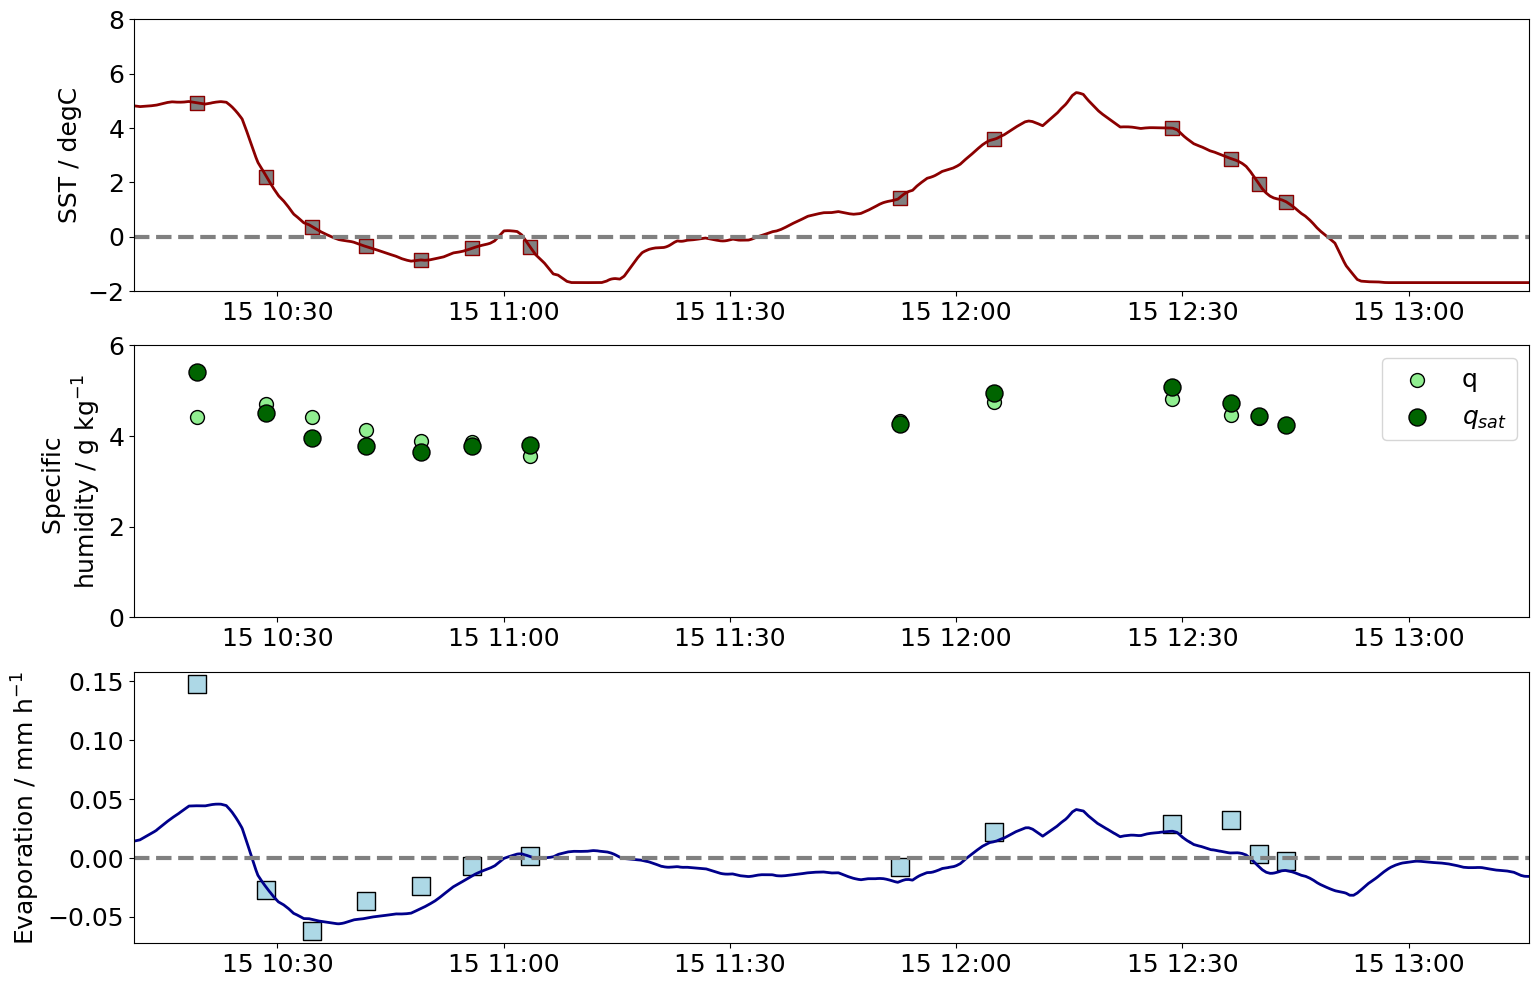

In [63]:
import matplotlib.pyplot as plt

evap_fig=plt.figure(figsize=(18,12))
ax1=evap_fig.add_subplot(311)
ax2=evap_fig.add_subplot(312,sharex=ax1)
ax3=evap_fig.add_subplot(313,sharex=ax1)

ax1.plot(sst-273.15,lw=2,ls="-",color="darkred")
ax1.scatter(surface_data.index,surface_data["ERA5_SST"].values-273.15,s=100,marker="s",color="grey",edgecolor="darkred")
ax1.axhline(y=0,ls="--",lw=3,color="grey")
ax1.set_ylim([-2,8])
ax1.set_ylabel("SST / degC")
ax2.scatter(surface_data.index,surface_data["Shum"]*1000, s=100, color="lightgreen", marker="o",edgecolor="k",label="q")
ax2.scatter(surface_data.index,surface_data["Qsat"]*1000, s=150, color="darkgreen", marker="o",edgecolor="k",label="$q_{sat}$")
ax2.set_ylabel("Specific \nhumidity / g kg$^{-1}$")
ax2.set_ylim([0,6])
ax2.legend()
ax3.plot(-halo_era5["Interp_E"],color="darkblue",lw=2,ls="-")
ax3.scatter(surface_data.index,surface_data["Evap"]/997*3600*1000, s=150, color="lightblue", marker="s",
            edgecolor="k",label="Evap_${\text{Sonde}}$")
ax3.axhline(y=0,ls="--",lw=3,color="grey")
ax3.set_ylabel("Evaporation / mm h$^{-1}$")
ax3.set_xlim([sst.index[0],sst.index[-1]])
fig_name="Sonde_Evap_"+flight[0]+"_"+ar_of_day+".png"
plot_path=os.getcwd()+"/../plots/"
evap_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as:",plot_path+fig_name)

## Manuscript Figure

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig08_Sonde_Evap_RF05_S1.png


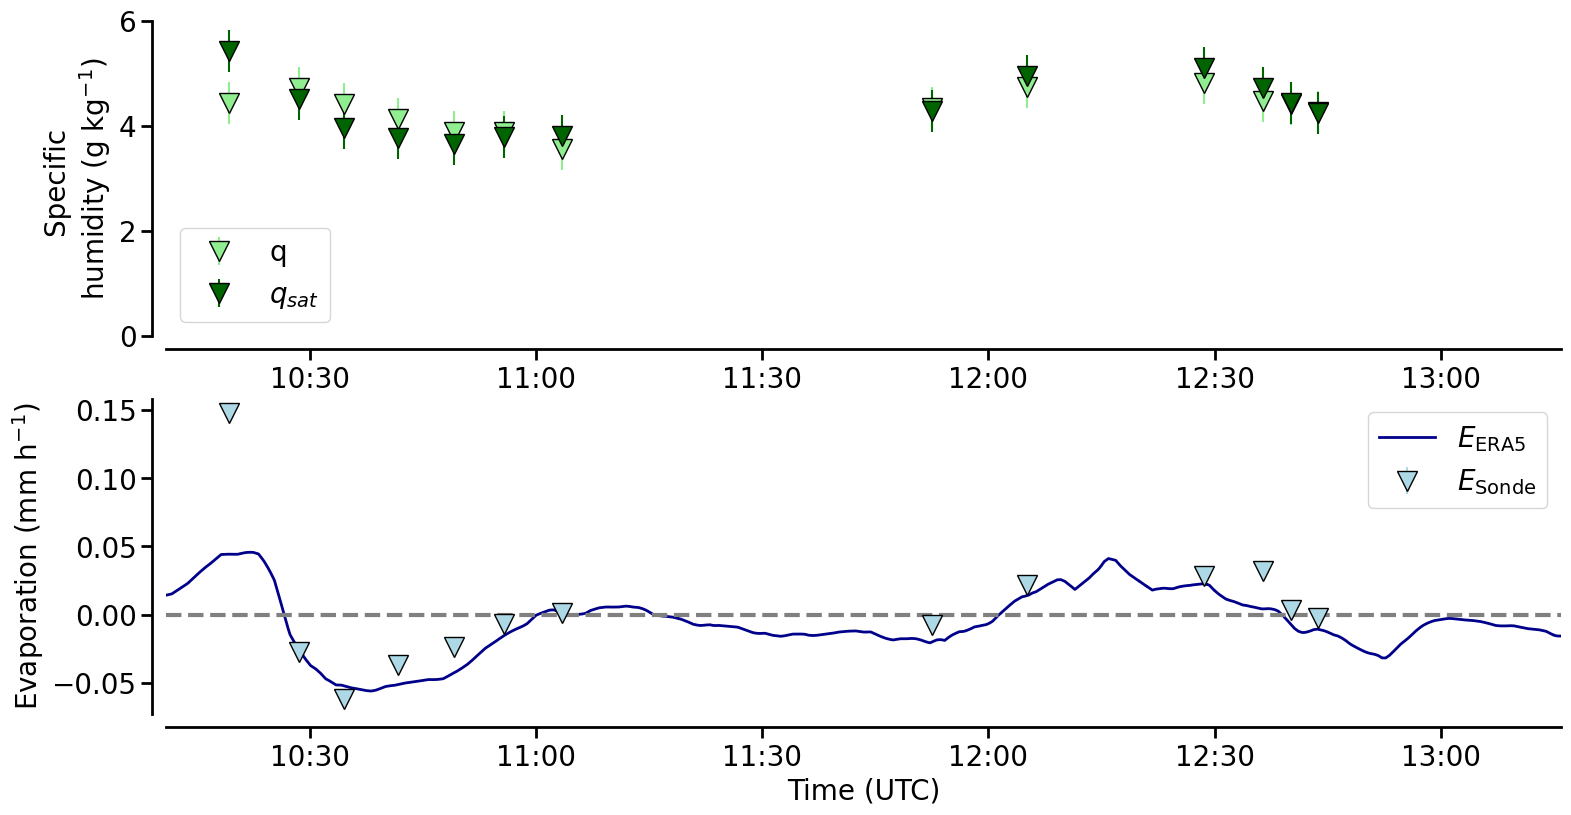

In [69]:
save_as_manuscript_plot=True
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

matplotlib.rcParams.update({"font.size":20})
evap_halo_fig=plt.figure(figsize=(18,9))
ax1=evap_halo_fig.add_subplot(211)
ax2=evap_halo_fig.add_subplot(212)
# Specific humidity
ax1.errorbar(surface_data.index,surface_data["Shum"]*1000, yerr=0.4, markersize=15, color="lightgreen", 
             marker="v",markeredgecolor="k",linestyle="",label="q")
ax1.errorbar(surface_data.index,surface_data["Qsat"]*1000, yerr=0.4, markersize=15, color="darkgreen",
             marker="v",markeredgecolor="k",linestyle="",label="$q_{sat}$")
ax1.set_ylabel("Specific \nhumidity (g kg$^{-1}$)")
ax1.set_ylim([0,6])
ax1.set_yticks([0,2,4,6])
ax1.legend()
# Evaporation
ax2.errorbar(surface_data.index,surface_data["Evap"]/997*3600*1000, yerr=surface_data["Evap_unc"],
             color="lightblue", marker='v',markeredgecolor="k",linestyle="",markersize=15,label="${E}_{\mathrm{Sonde}}$")
ax2.plot(-halo_era5["Interp_E"],color="darkblue",lw=2,ls="-",label="${E}_{\mathrm{ERA5}}$")
ax2.axhline(y=0,ls="--",lw=3,color="grey")
ax2.set_ylabel("Evaporation (mm h$^{-1}$)")
ax2.legend()
ax1.set_xlim([sst.index[0],sst.index[-1]])
ax2.set_xlim([sst.index[0],sst.index[-1]])
ax1.spines["left"].set_linewidth(2)
ax1.spines["bottom"].set_linewidth(2)
ax2.spines["left"].set_linewidth(2)
ax2.spines["bottom"].set_linewidth(2)
ax1.tick_params(axis="x",width=2,length=8)
ax2.tick_params(axis="x",width=2,length=8)
ax1.tick_params(axis="y",width=2,length=8)
ax2.tick_params(axis="y",width=2,length=8)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_xlabel("Time (UTC)")
fig_name="Sonde_Evap_"+flight[0]+"_S1.png"
sns.despine(offset=10)
if save_as_manuscript_plot:
    fig_name="Fig08_"+fig_name
plot_path=os.getcwd()+"/../plots/"
evap_halo_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as:",plot_path+fig_name) 

In [17]:
inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]

warm_era5_evap=halo_era5["Interp_E"].copy()*-1
warm_era5_evap.loc["2022-03-15 10:45":"2022-03-15 11:45"]=np.nan
warm_era5_evap.loc["2022-03-15 12:48":"2022-03-15 13:15"]=np.nan
warm_era5_evap.mean()

0.0005174798818550748